In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import xarray as xr #Для чтения данных с сайта IRI
from datetime import datetime as dt
import pyodbc #Для загрузки данных из базы

#Для чтения doc файлов - понадобится, чтобы загрузить статистику
import io
import csv
from docx import Document

#Укажем номер прогнозной модели.
#Он также означает на какое колличество месяцев вперед нужно сместить дату, чтобы получить пронгозные данные
lag = 4

#Дата запуска кода - для сохранения результатов с указанием даты
current_date = str(dt.now())[:10]

In [2]:
#Закачаем актуальные данные с IRI
#Укажем долготу и широту для которых хотим получить прогноз IRI
dolg = ['89.0', '118.0'];
shir = ['49', '60'];

GES_name = {'IRK': 'Иркутская ГЭС', 'SHA': 'Саяно-Шушенская ГЭС', 'KRA': 'Красноярская ГЭС',
            'BRA': 'Братская ГЭС', 'UIM': 'Усть-Илимская ГЭС', 'BOG': 'Богучанская ГЭС'};

url = f"""http://iridl.ldeo.columbia.edu/SOURCES/.Models/.NMME/.NCEP-CFSv2/.FORECAST/\
.PENTAD_SAMPLES/.MONTHLY/.prec/\
X/{dolg[0]}/{dolg[1]}/RANGEEDGES/\
Y/{shir[0]}/{shir[1]}/RANGEEDGES/\
dods""";

ddos = xr.open_dataset(url, decode_times=False);
ddos['S'].attrs['calendar'] = '360_day';
ddos = xr.decode_cf(ddos, decode_times=True);

ddos = ddos.rename({'S': 'Дата', #Forecast_reference_time. Grid: /S (months since 1960-01-01) ordered (0000 1 Apr 2011) to (0000 1 Mar 2022) by 1.0 N= 132 pts :grid
                    #сетка число месяцев месяцев с 1 января 1960 г. с 0000 1 апреля 2011 г. по 0000 1 марта 2022 г.
                    'L': 'lead', #L. Grid: /L (months) ordered (0.5 months) to (9.5 months) by 1.0 N= 10 pts :grid
                    #сетка месяцев от 0,5 месяцев 9,5 месяцев
                    'M': 'member', #M. Grid: /M (unitless) ordered (1.0) to (28.0) by 1.0 N= 28 pts :grid
                    #сетка моделей (безразмерная от 1,0 до 28,0). IRI агрегирует 28 результатов других моделей. Далее мы их усредним, чтобы снизить ошибку.
                    'X': 'lon', #Longitude (longitude). Grid: /X (degree_east) ordered (89E) to (118E) by 1.0 N= 30 pts :grid
                    #Долгота упорядочена 89E до 118E
                    'Y': 'lat' #Latitude (latitude). Grid: /Y (degree_north) ordered (49N) to (60N) by 1.0 N= 12 pts :grid
                    #Широта упорядочена от 49N до 60N
                   });

ddos['lead'] = (ddos['lead']-0.5).astype('int'); #Значения записаны ка 0.5, 1.5, ... приводим к целы числам. Зачем - не понял
ddos['Дата'] = pd.to_datetime(ddos['Дата'].values.astype(str), yearfirst=True);
ddos

<xarray.Dataset>
Dimensions:  (lead: 10, Дата: 162, member: 28, lon: 30, lat: 12)
Coordinates:
  * lead     (lead) int32 0 1 2 3 4 5 6 7 8 9
  * Дата     (Дата) datetime64[ns] 2011-04-01 2011-05-01 ... 2024-09-01
  * member   (member) float32 1.0 2.0 3.0 4.0 5.0 ... 24.0 25.0 26.0 27.0 28.0
  * lon      (lon) float32 89.0 90.0 91.0 92.0 93.0 ... 115.0 116.0 117.0 118.0
  * lat      (lat) float32 49.0 50.0 51.0 52.0 53.0 ... 56.0 57.0 58.0 59.0 60.0
Data variables:
    prec     (Дата, lead, member, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL

In [7]:
# Definir el rango de fechas manualmente
fecha_inicio = '2011-04-01'  # Fecha de inicio en formato YYYY-MM-DD
fecha_fin = '2022-04-01'     # Fecha de fin en formato YYYY-MM-DD

# Seleccionar los datos dentro del rango de fechas especificado
ddos = ddos.sel(Дата=slice(fecha_inicio, fecha_fin))
ddos

<xarray.Dataset>
Dimensions:  (lead: 10, Дата: 133, member: 28, lon: 30, lat: 12)
Coordinates:
  * lead     (lead) int32 0 1 2 3 4 5 6 7 8 9
  * Дата     (Дата) datetime64[ns] 2011-04-01 2011-05-01 ... 2022-04-01
  * member   (member) float32 1.0 2.0 3.0 4.0 5.0 ... 24.0 25.0 26.0 27.0 28.0
  * lon      (lon) float32 89.0 90.0 91.0 92.0 93.0 ... 115.0 116.0 117.0 118.0
  * lat      (lat) float32 49.0 50.0 51.0 52.0 53.0 ... 56.0 57.0 58.0 59.0 60.0
Data variables:
    prec     (Дата, lead, member, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL

In [6]:
# Especificamos la longitud y latitud para las cuales queremos obtener el pronóstico del IRI
dolg = ['-74.89', '-68.39']  # Longitudes
shir = ['-18.39', '-9.09'] 

GES_name = {'IRK': 'Иркутская ГЭС', 'SHA': 'Саяно-Шушенская ГЭС', 'KRA': 'Красноярская ГЭС',
            'BRA': 'Братская ГЭС', 'UIM': 'Усть-Илимская ГЭС', 'BOG': 'Богучанская ГЭС'};

url = f"""https://iridl.ldeo.columbia.edu/SOURCES/.SENAMHI/.HSR/.PISCO/.Prec/\
.v2p1/.stable/.daily/.Prec/\
X/{dolg[0]}/{dolg[1]}/RANGEEDGES/\
Y/{shir[0]}/{shir[1]}/RANGEEDGES/\
dods""";

ddos = xr.open_dataset(url, decode_times=False);
#ddos['T'].attrs['calendar'] = '360_day'; # of month
ddos = xr.decode_cf(ddos, decode_times=True);

ddos = ddos.rename({'T': 'Dаtа', #Forecast_reference_time. Grid: /S (months since 1960-01-01) ordered (0000 1 Apr 2011) to (0000 1 Mar 2022) by 1.0 N= 132 pts :grid
                    #сетка число месяцев месяцев с 1 января 1960 г. с 0000 1 апреля 2011 г. по 0000 1 марта 2022 г. 
                    'X': 'lon', #Longitude (longitude). Grid: /X (degree_east) ordered (89E) to (118E) by 1.0 N= 30 pts :grid
                    #Долгота упорядочена 89E до 118E
                    'Y': 'lat' #Latitude (latitude). Grid: /Y (degree_north) ordered (49N) to (60N) by 1.0 N= 12 pts :grid
                    #Широта упорядочена от 49N до 60N
                   });


#ddos['lead'] = (ddos['lead']-0.5).astype('int'); #Значения записаны ка 0.5, 1.5, ... приводим к целы числам. Зачем - не понял
ddos['Dаtа'] = pd.to_datetime(ddos['Dаtа'].values.astype(str), yearfirst=True);
ddos

<xarray.Dataset>
Dimensions:  (Dаtа: 13149, lon: 66, lat: 94)
Coordinates:
  * Dаtа     (Dаtа) datetime64[ns] 1981-01-01T12:00:00 ... 2016-12-31T12:00:00
  * lon      (lon) float32 -74.85 -74.75 -74.65 -74.55 ... -68.55 -68.45 -68.35
  * lat      (lat) float32 -18.35 -18.25 -18.15 -18.05 ... -9.25 -9.15 -9.05
Data variables:
    Prec     (Dаtа, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL

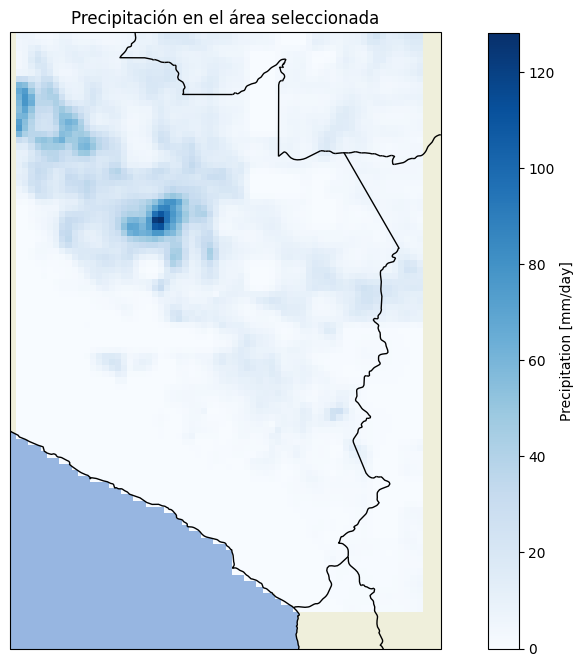

In [7]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
# Ploteamos los datos
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-75, -68, -19, -9], crs=ccrs.PlateCarree())  # Extensión del área de interés
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)

# Seleccionamos los datos de precipitación (ajusta según el nombre real de la variable)
precip_data = ddos['Prec']  # Asegúrate de usar el nombre correcto de la variable

# Ploteamos la primera fecha de los datos
precip_data.isel(Dаtа=0).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='Blues', add_colorbar=True)

# Añadimos títulos y etiquetas
plt.title('Precipitación en el área seleccionada')
plt.xlabel('Longitud')
plt.ylabel('Latitud')
plt.show()

In [8]:
locations = pd.read_csv("D:/Paper_Climate/Data/siguiente paper/of interpolation/CDBC.csv")

# Asegúrate de que las fechas se interpreten correctamente
ddos['Dаtа'] = pd.to_datetime(ddos['Dаtа'].values.astype(str), yearfirst=True)

# Crear un conjunto de datos que contiene los valores de precipitación para cada ubicación
prec = xr.Dataset()

for index, row in locations.iterrows():
    nombre = f'V{index + 1}'  # Usando el índice para nombrar la variable
    longitude = row['LON']
    latitude = row['LAT']

    # Seleccionar los datos de precipitación más cercanos
    ds2 = ddos.sel(lon=longitude, lat=latitude, method='nearest')

    # Renombrar la variable y agregar a 'prec'
    ds2 = ds2.rename({'Prec': nombre})  # Cambia 'precipitation_variable_name' por el nombre correcto
    prec = xr.merge([prec, ds2], compat='override')

# Visualizar las variables de precipitación
print(prec.data_vars)

Data variables:
    V1       (Dаtа) float32 ...
    V2       (Dаtа) float32 ...
    V3       (Dаtа) float32 ...
    V4       (Dаtа) float32 ...
    V5       (Dаtа) float32 ...
    V6       (Dаtа) float32 ...
    V7       (Dаtа) float32 ...
    V8       (Dаtа) float32 ...
    V9       (Dаtа) float32 ...
    V10      (Dаtа) float32 ...
    V11      (Dаtа) float32 ...
    V12      (Dаtа) float32 ...
    V13      (Dаtа) float32 ...
    V14      (Dаtа) float32 ...
    V15      (Dаtа) float32 ...
    V16      (Dаtа) float32 ...
    V17      (Dаtа) float32 ...
    V18      (Dаtа) float32 ...
    V19      (Dаtа) float32 ...
    V20      (Dаtа) float32 ...
    V21      (Dаtа) float32 ...
    V22      (Dаtа) float32 ...
    V23      (Dаtа) float32 ...
    V24      (Dаtа) float32 ...
    V25      (Dаtа) float32 ...
    V26      (Dаtа) float32 ...
    V27      (Dаtа) float32 ...
    V28      (Dаtа) float32 ...
    V29      (Dаtа) float32 ...
    V30      (Dаtа) float32 ...


C:\Users\ASUS\anaconda3\Lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
C:\Users\ASUS\anaconda3\Lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
C:\Users\ASUS\anaconda3\Lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  indexer = self.index.get_loc(
C:\Users\ASUS\anaconda3\Lib\site-packages\xarray\core\indexes.py:234: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  in

In [9]:
prec_df = prec.to_dataframe().reset_index()


In [49]:
# Formato de fecha
prec_df['Dаtа'] = pd.to_datetime(prec_df['Dаtа']).dt.strftime('%d/%m/%Y')

# Crear una lista para los datos finales
final_data = []

final_data.append(['N'] + locations['LAT'].values.tolist())
final_data.append(['E'] + locations['LON'].values.tolist())

# Agregar las fechas y los valores de precipitación
for index, row in prec_df.iterrows():
    # Obtener la fecha
    fecha = row['Dаtа']
    
    # Solo mantener los valores de precipitación
    formatted_precip = [f"{val:.2f}" if pd.notnull(val) and val != -999 else '' for val in row[2:].values.tolist()]
    
    # Unir fecha con los valores de precipitación
    final_data.append([fecha] + formatted_precip)

# Crear un DataFrame a partir de la lista
final_df = pd.DataFrame(final_data)

# Ajustar las columnas de precipitación
final_df.iloc[2:, 1:] = final_df.iloc[2:, 1:].apply(pd.to_numeric, errors='coerce')

C:\Users\ASUS\AppData\Local\Temp\ipykernel_22572\3723008163.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  prec_df['Dаtа'] = pd.to_datetime(prec_df['Dаtа']).dt.strftime('%d/%m/%Y')


In [42]:
# Guardar el DataFrame como CSV
csv_file_path = 'D:/Paper_Climate/Data/siguiente paper/of interpolation/siguiente_paper_precipitacion.csv'
final_df.to_csv(csv_file_path, index=False, header=False)

In [12]:
# Seleccionar los datos dentro del rango de fechas especificado
ddos = ddos.sel(Dаtа=slice('2011-04-01', '2022-04-01'))
ddos

<xarray.Dataset>
Dimensions:  (Dаtа: 2102, lon: 66, lat: 94)
Coordinates:
  * Dаtа     (Dаtа) datetime64[ns] 2011-04-01T12:00:00 ... 2016-12-31T12:00:00
  * lon      (lon) float32 -74.85 -74.75 -74.65 -74.55 ... -68.55 -68.45 -68.35
  * lat      (lat) float32 -18.35 -18.25 -18.15 -18.05 ... -9.25 -9.15 -9.05
Data variables:
    Prec     (Dаtа, lat, lon) float32 ...
Attributes:
    Conventions:  IRIDL

In [ ]:
# Lee las coordenadas desde el archivo CSV
ubicaciones_df = pd.read_csv("D:/Paper_Climate/Data/siguiente paper/of interpolation/CDBC.csv")

# Crea la lista de ubicaciones desde el DataFram
locs = ubicaciones_df.to_dict(orient='records')
locs

In [8]:
# Guardamos todo en un DataFrame
fullda = ddos.to_dataframe()
fullda

prec
lead Дата       member lon   lat          
0    2011-04-01 1.0    89.0  49.0  1.90944
                             50.0  2.85552
                             51.0  3.25188
                             52.0  3.99357
                             53.0  5.92461
...                                    ...
9    2022-04-01 28.0   118.0 56.0      NaN
                             57.0      NaN
                             58.0      NaN
                             59.0      NaN
                             60.0      NaN

[13406400 rows x 1 columns]

In [12]:
# Asegurémonos de que el índice esté bien alineado y no contenga errores
for i in range(1, lag):
    try:
        # Verificar que 'lat' y otros índices están bien especificados
        target_lat = fullda.index.get_level_values('lat').unique()[-i]
        if 6 in fullda.index.get_level_values('lead').unique():
            fullda.loc[(slice(None), 6, slice(None), slice(None), target_lat), 'prec'] = fullda.loc[
                (slice(None), i, slice(None), slice(None), fullda.index.get_level_values('lat').unique()[-1]), 'prec'].values
        else:
            print(f"Índice 6 no existe en los datos.")
    except KeyError as e:
        print(f"Error con el índice {i}: {e}")

# Mostrar el DataFrame para verificar los cambios
print(fullda.head())





Error con el índice 1: 1
Error con el índice 2: 2
Error con el índice 3: 3
                                     prec
lead Дата       member lon  lat          
0    2011-04-01 1.0    89.0 49.0  1.90944
                            50.0  2.85552
                            51.0  3.25188
                            52.0  3.99357
                            53.0  5.92461


In [17]:
# Para los meses de pronóstico más cercanos, guardamos los datos de los modelos de pronóstico con el desplazamiento mínimo conocido
# Si lag=6, entonces para el mes siguiente guardamos los datos con lag=1, para dos meses adelante lag=2 y así sucesivamente
for i in range(1, lag):
    try:
        # Verificar que el índice '6' y el índice '-i' existan en los valores únicos
        if 6 in fullda.index.get_level_values('lead') and (fullda.index.get_level_values('Дата').max() in fullda.index.get_level_values('Дата')) and (fullda.index.get_level_values('lat').max() in fullda.index.get_level_values('lat')):
            # Usar el último valor disponible para 'lat' si '-i' es negativo
            target_lat = fullda.index.get_level_values('lat').unique()[-i] if i <= len(fullda.index.get_level_values('lat')) else None
            
            if target_lat is not None:
                fullda.loc[(slice(None), 6, slice(None), slice(None), target_lat), 'prec'] = fullda.loc[
                    (slice(None), i, slice(None), slice(None), fullda.index.get_level_values('lat').max()), 'prec'].values
            else:
                print(f"Índice -{i} para latitud no es válido.")
        else:
            print(f"Índice 6, fecha final o latitud no existe en los datos.")
    except KeyError as e:
        print(f"Error con el índice {i}: {e}")

# Mostrar el DataFrame para verificar los cambios
print(fullda.head())





Error con el índice 1: 1
Error con el índice 2: 2
Error con el índice 3: 3
                                     prec
lead Дата       member lon  lat          
0    2011-04-01 1.0    89.0 49.0  1.90944
                            50.0  2.85552
                            51.0  3.25188
                            52.0  3.99357
                            53.0  5.92461


ValueError: Could not interpret value `prec` for parameter `y`

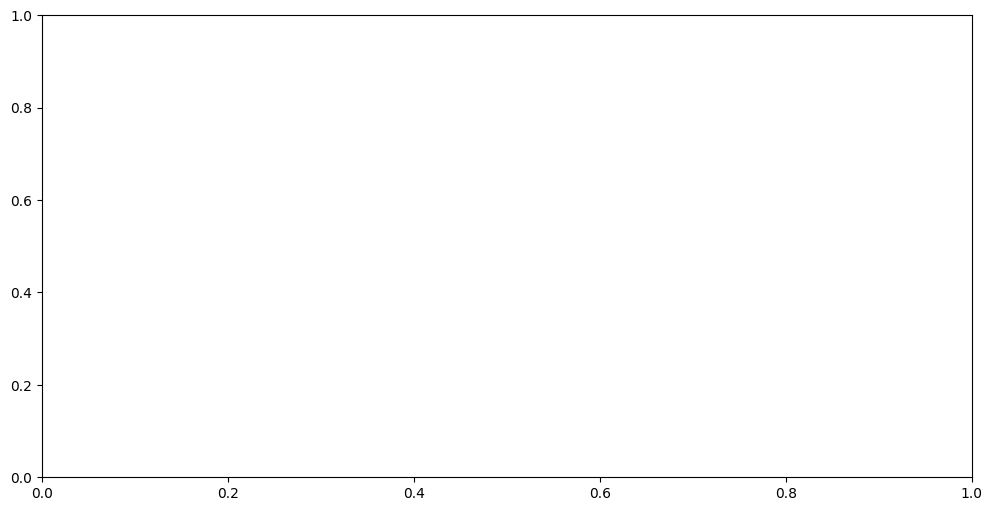

In [18]:
plt.subplots(figsize=(12,6));
sns.lineplot(data=fullda.groupby(['Dаtа']).mean(1), y='prec', x="Dаtа", palette='crest');
plt.title('Все прогнозные модели IRI');
plt.savefig(f'../data/Исходные данные/Данные с сайта IRI/Графики/{current_date} Пргнозные модели IRI.png', dpi=200);
plt.show()

